In [1]:
import pandas as pd
import numpy as np
df_empresas_estab_mg = pd.read_csv("data/df_empresas_estab_mg.csv")
df_naturezas = pd.read_csv("data/Naturezas0.csv")
df_cnaes = pd.read_csv("data/Cnaes0.csv")
df_qualificacoes = pd.read_csv("data/Qualificacoes0.csv")

In [2]:
df_empresas_estab_mg = df_empresas_estab_mg[df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE'] > '1900-01-01']

In [3]:
df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE'] = pd.to_datetime(df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE'])
df_empresas_estab_mg['IDADE'] = (pd.Timestamp('now') - df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE']) / np.timedelta64(1, 'D')

In [4]:
from sklearn.model_selection import train_test_split
colunas_modelo = ['NATUREZA', 'CAPITAL', 'PORTE', 'IDENTIFICADOR MATRIZ/FILIAL', 'CNAE FISCAL PRINCIPAL', 'QUALIFICAÇÃO', 'IDADE']


In [5]:
first = 30
first_naturezas = df_empresas_estab_mg.groupby('NATUREZA')['cnpj'].count().sort_values(ascending=False).head(first).index
first_cnaes = df_empresas_estab_mg.groupby('CNAE FISCAL PRINCIPAL')['cnpj'].count().sort_values(ascending=False).head(first).index
first_qualificacoes = df_empresas_estab_mg.groupby('QUALIFICAÇÃO')['cnpj'].count().sort_values(ascending=False).head(first).index

In [6]:
for column, list_ in zip(['NATUREZA', 'CNAE FISCAL PRINCIPAL', 'QUALIFICAÇÃO'], [first_naturezas, first_cnaes, first_qualificacoes]):
    df_empresas_estab_mg[column] = df_empresas_estab_mg[column].apply(lambda x: x if x in list_ else -1)

In [7]:
df_empresas_estab_mg['target'] = df_empresas_estab_mg['SITUAÇÃO CADASTRAL'].apply(lambda x: 1 if x == 2 else 0)
df_empresas_estab_mg['CAPITAL'] = df_empresas_estab_mg['CAPITAL'].apply(lambda x: x.replace(',', '.')).astype(float)
colunas_encoder = ['NATUREZA', 'PORTE', 'IDENTIFICADOR MATRIZ/FILIAL', 'CNAE FISCAL PRINCIPAL', 'QUALIFICAÇÃO']
df_empresas_estab_mg[colunas_encoder] = df_empresas_estab_mg[colunas_encoder].fillna(0).astype(int)


In [8]:
x_train, x_test, y_train,y_test = train_test_split(df_empresas_estab_mg[colunas_modelo], df_empresas_estab_mg['target'], test_size=0.2, random_state=42)

In [9]:
x_train

,NATUREZA,CAPITAL,PORTE,IDENTIFICADOR MATRIZ/FILIAL,CNAE FISCAL PRINCIPAL,QUALIFICAÇÃO,IDADE
5263590,2135,1000.0,1,1,-1,50,1088.640422
4187327,4090,0.0,5,1,9492800,51,2382.640422
185614,2135,0.0,5,1,-1,50,11212.640422
2996784,2135,1000.0,1,1,-1,50,3414.640422
109853,2135,2200.0,1,1,4781400,50,654.640422
...,...,...,...,...,...,...,...
1570007,2062,0.0,1,1,5611201,49,6955.640422
2234490,2062,10000.0,1,1,4930202,49,4364.640422
4926485,2135,5000.0,1,1,-1,50,1439.640422
4304573,2135,10000.0,1,1,-1,50,2236.640422


In [66]:
x_test

,NATUREZA,CAPITAL,PORTE,IDENTIFICADOR MATRIZ/FILIAL,CNAE FISCAL PRINCIPAL,QUALIFICAÇÃO,IDADE
2098380,2135,1000.0,1,1,-1,50,4721.640422
4541210,2135,70000.0,1,1,-1,50,1893.640422
4108250,2062,0.0,1,1,-1,49,12403.640422
2253389,2062,10000.0,1,1,-1,49,4316.640422
4467910,2135,600.0,1,1,9602501,50,2010.640422
...,...,...,...,...,...,...,...
635145,2135,5000.0,1,1,4781400,50,219.640422
988641,3085,0.0,5,1,8112500,19,10530.640422
4998140,2321,3000.0,5,1,-1,65,1362.640422
4915302,2135,50000.0,1,1,-1,50,1448.640422


In [52]:
not_encoder = ['CAPITAL', 'IDADE']

In [63]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
ohe = OneHotEncoder(handle_unknown='ignore')

ct = make_column_transformer(
    (ohe, colunas_encoder),
    remainder='passthrough'
)
ct.fit(x_train)

x_train_encoded = ct.transform(x_train)
x_test_encoded = ct.transform(x_test)



In [55]:
cols = list(ct.named_transformers_['onehotencoder'].get_feature_names_out()) + not_encoder

In [11]:
import xgboost as xgb
from scipy.sparse import csr_matrix

dtrain = xgb.DMatrix(x_train_encoded, label=y_train)

xgb_clf = xgb.XGBClassifier()

In [12]:
x_train_data = dtrain.get_data()
y_train_data = dtrain.get_label()

In [13]:
%%time
xgb_clf.fit(x_train_data, y_train_data)

CPU times: total: 8min 32s
Wall time: 1min 39s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
# Fazer previsões com o modelo
dtest = xgb.DMatrix(x_test_encoded)

In [15]:
y_pred = xgb_clf.predict(dtest.get_data())
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)

In [17]:
print("Matriz de Confusão:\n", cm)
print("Acurácia: {:.2f}%".format(acc*100))
print("F1 Score: {:.2f}%".format(f1*100))
print("Precision: {:.2f}%".format(ps*100))


Matriz de Confusão:
 [[603478  97248]
 [159305 292310]]
Acurácia: 77.74%
F1 Score: 69.50%
Precision: 75.04%


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Definir as classes
classes = ['Empresa fechada', 'Empresa ativa']
# Especificar uma paleta de cores
def plot_matriz(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.light_palette("green", as_cmap=True)


    # Plotar a matriz de confusão
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, cmap=cmap)

    # Adicionar as labels dos eixos
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # Adicionar as labels das células
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

    # Adicionar o título e a barra de cores
    # ax.set_title('Matriz de Confusão')
    plt.colorbar(im, ax=ax)

    # Mostrar a figura
    plt.show()
    
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_bar = confusion_matrix(y_test, y_pred, normalize='true')*100
    cmap = sns.light_palette("green", as_cmap=True)
    
    cm_rounded = np.around(cm, decimals=4)

    # Formatando os valores como porcentagens
    cm_percent = np.vectorize(lambda x: '{:.2%}'.format(x))(cm_rounded)



    # Plotar a matriz de confusão
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm_bar, cmap=cmap)

    # Adicionar as labels dos eixos
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    # Adicionar as labels das células
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, cm_percent[i, j], ha='center', va='center', color='black')

    # Adicionar o título e a barra de cores
    # ax.set_title('Matriz de Confusão')
    plt.colorbar(im, ax=ax)

    # Mostrar a figura
    plt.show()
    
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ps = precision_score(y_test, y_pred)
    

    print("Matriz de Confusão:\n", cm)
    print("Matriz de confusao percent", cm_percent)
    print("Acurácia: {:.2f}%".format(acc*100))
    print("F1 Score: {:.2f}%".format(f1*100))
    print("Precision: {:.2f}%".format(ps*100))



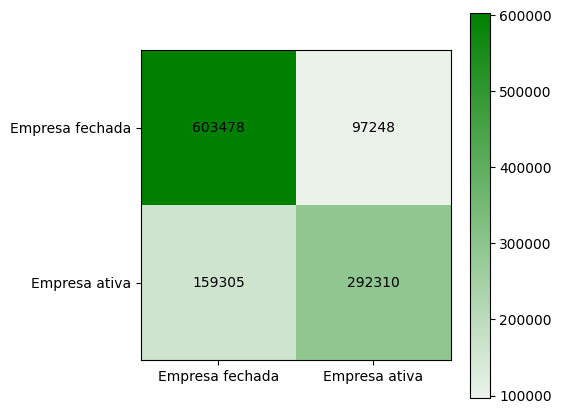

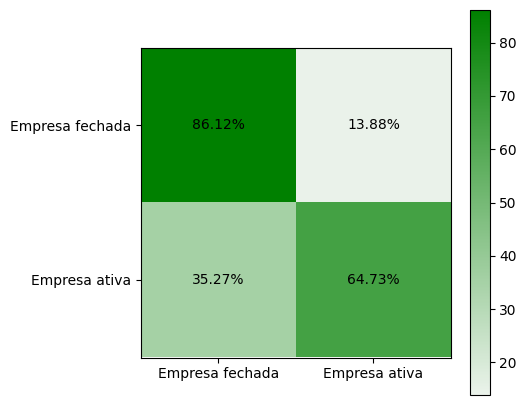

Matriz de Confusão:
 [[603478  97248]
 [159305 292310]]
Matriz de confusao percent [['86.12%' '13.88%']
 ['35.27%' '64.73%']]
Acurácia: 77.74%
F1 Score: 69.50%
Precision: 75.04%


In [19]:
plot_matriz(y_test, y_pred)

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10)


In [21]:
%%time
rf.fit(x_train_encoded, y_train)

CPU times: total: 10min 5s
Wall time: 10min 9s


RandomForestClassifier(max_depth=10)

In [22]:
y_pred = rf.predict(x_test_encoded)


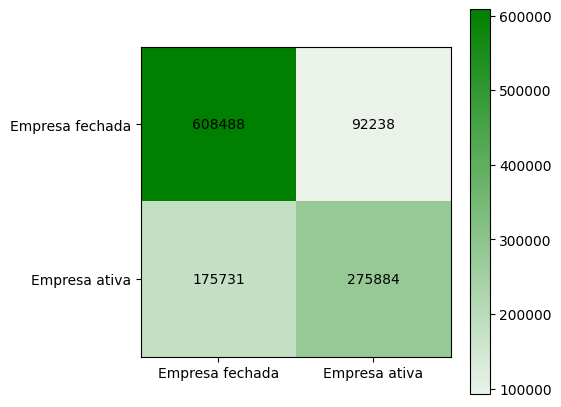

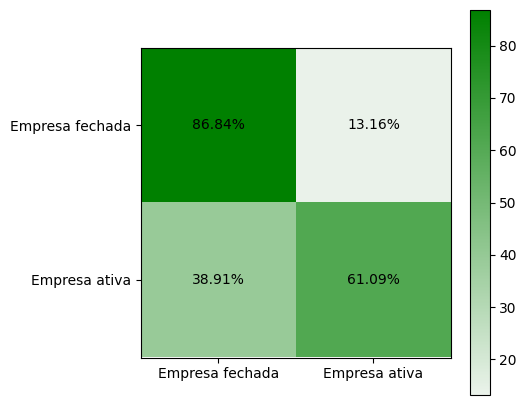

Matriz de Confusão:
 [[608488  92238]
 [175731 275884]]
Matriz de confusao percent [['86.84%' '13.16%']
 ['38.91%' '61.09%']]
Acurácia: 76.75%
F1 Score: 67.31%
Precision: 74.94%


In [23]:
plot_matriz(y_test, y_pred)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)
print("Acurácia: {:.2f}%".format(acc*100))

Matriz de Confusão:
 [[608488  92238]
 [175731 275884]]
Acurácia: 76.75%


In [25]:
# pip install lightgbm

In [26]:
import lightgbm as lgb
train_data = lgb.Dataset(x_train_encoded,  label=y_train)
num_round = 10
params = {
    "objective": "binary",
}




In [27]:
%%time
bst = lgb.LGBMClassifier(**params)
bst.fit(x_train_encoded, y_train)

CPU times: total: 1min 44s
Wall time: 17 s


LGBMClassifier(objective='binary')

In [28]:
import scipy.sparse as sp

# assumindo que sua matriz esparsa é chamada de sparse_matrix
sparse_matrix_csr = sp.csr_matrix(x_test_encoded)

y_pred = bst.predict(sparse_matrix_csr)

In [29]:
y_pred

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

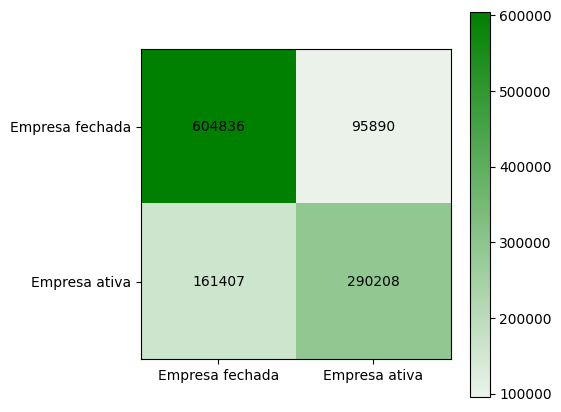

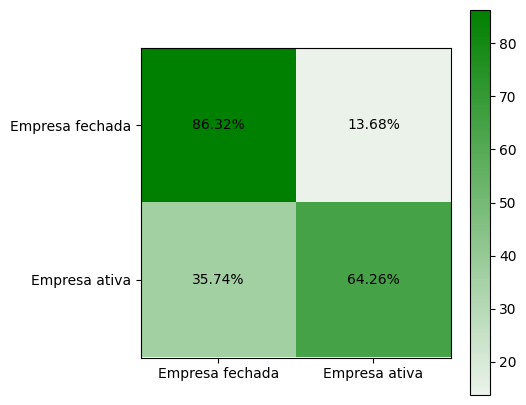

Matriz de Confusão:
 [[604836  95890]
 [161407 290208]]
Matriz de confusao percent [['86.32%' '13.68%']
 ['35.74%' '64.26%']]
Acurácia: 77.67%
F1 Score: 69.29%
Precision: 75.16%


In [30]:
plot_matriz(y_test, y_pred)

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)
print("Acurácia: {:.2f}%".format(acc*100))

Matriz de Confusão:
 [[604836  95890]
 [161407 290208]]
Acurácia: 77.67%


In [32]:
# Obtenha as probabilidades previstas para cada classe
y_pred_proba = rf.predict_proba(x_test_encoded)


In [100]:
def plot_feature_importances(importances, feature_names, model_name):
    # Ordenar as features por importância
    indices = np.argsort(importances)[::-1]
    top_features = 10

    # Selecionar as top_features mais importantes
    sorted_importances = importances[indices][:top_features]
    sorted_feature_names = feature_names[indices][:top_features]

    # Plotar o gráfico
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(range(top_features), sorted_importances, align='center')
    ax.set_yticks(range(top_features))
    ax.set_yticklabels(sorted_feature_names)
    ax.set_xlabel('Importance')
    ax.set_title(f'{model_name} Feature Importances (Top {top_features})')
    
    for i, v in enumerate(sorted_importances):
        ax.text(v, i, f'{v:.2f}', color='black', ha='left', va='center', fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()


In [101]:
importances = xgb_clf.feature_importances_
lgb_importances = bst.feature_importances_
rf_importances = rf.feature_importances_


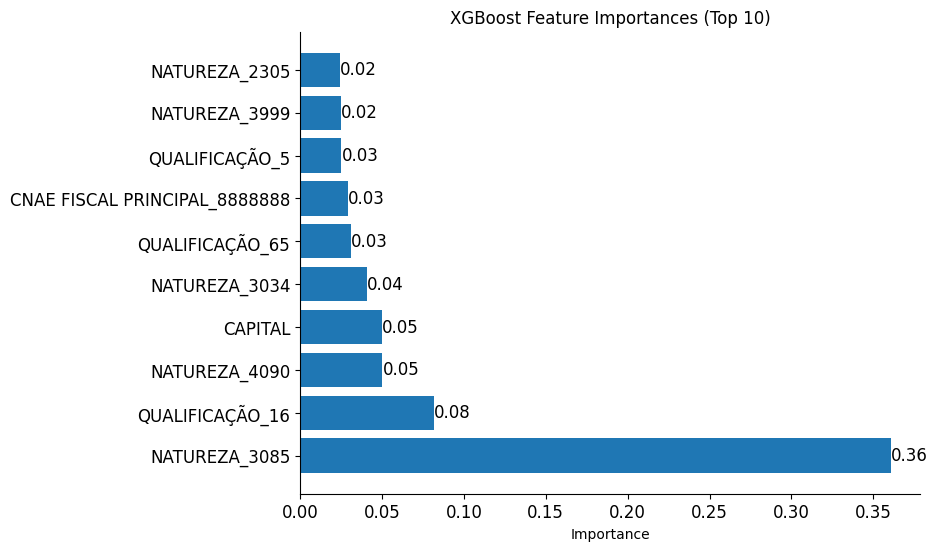

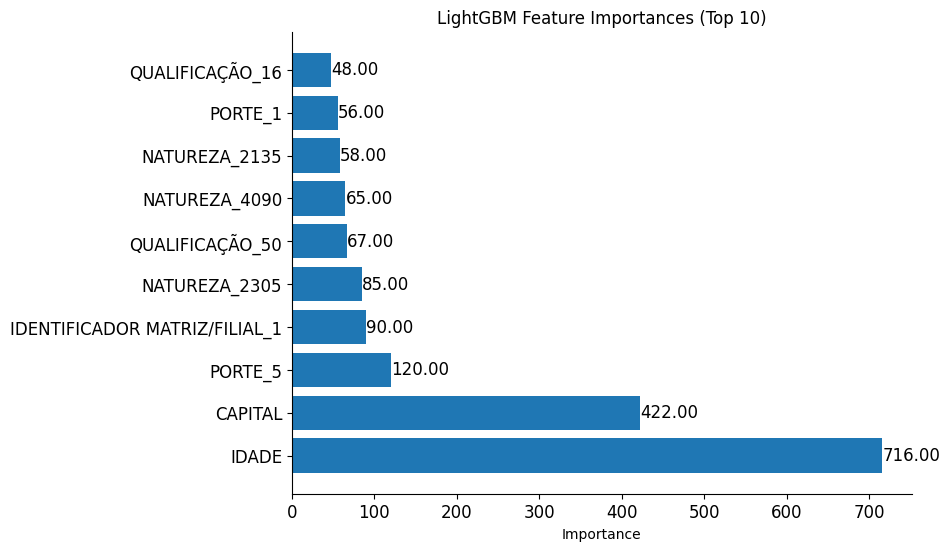

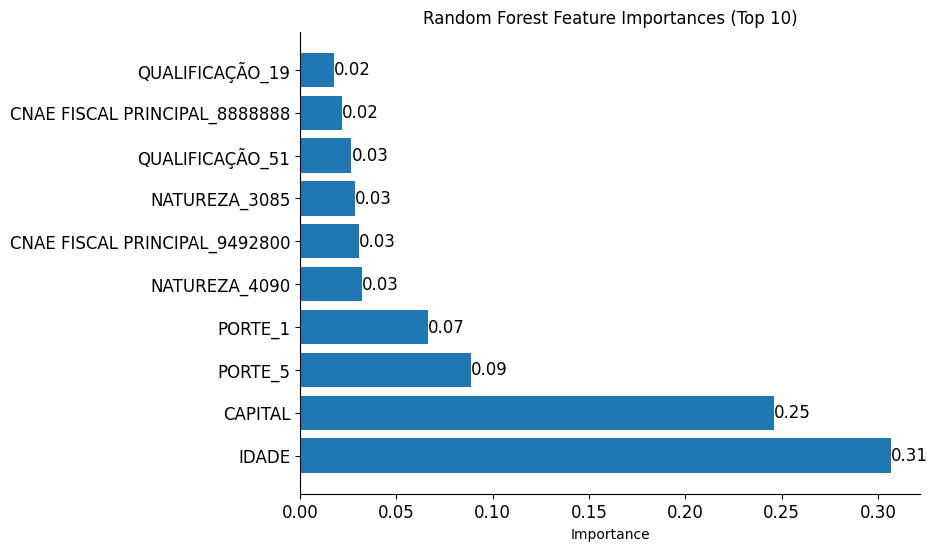

In [102]:
plot_feature_importances(importances, np.array(cols), 'XGBoost')
plot_feature_importances(lgb_importances, np.array(cols), 'LightGBM')
plot_feature_importances(rf_importances, np.array(cols), 'Random Forest')
